# PROMUEVA

  Ronda  OP1  OP2  OP3  OP4  OP5
0    R1    9   42   28   37   11
1    R2   19   37   21   34   13
2    R3   10   21   14   48   18
3    R4    8   24   19   40   14
4    R5   11   26   20   31    9
['0.386', '0.419', '0.405', '0.394', '0.399']


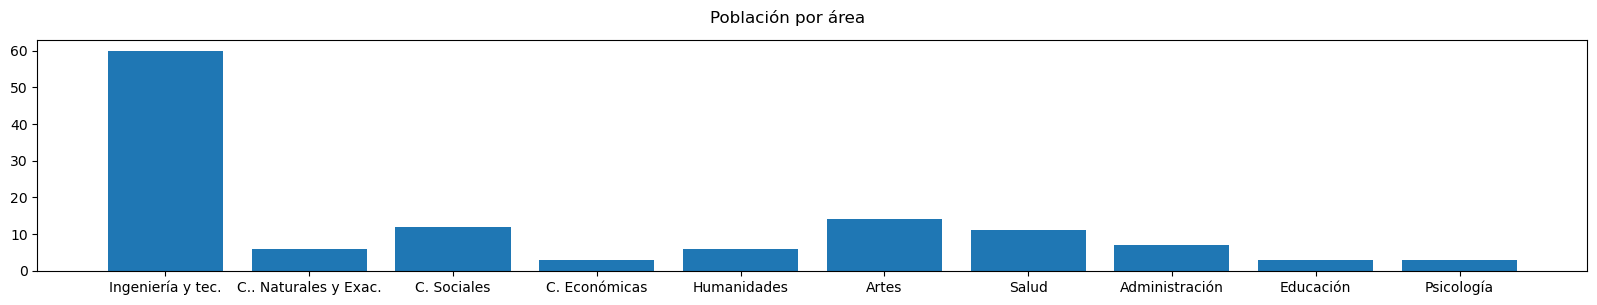

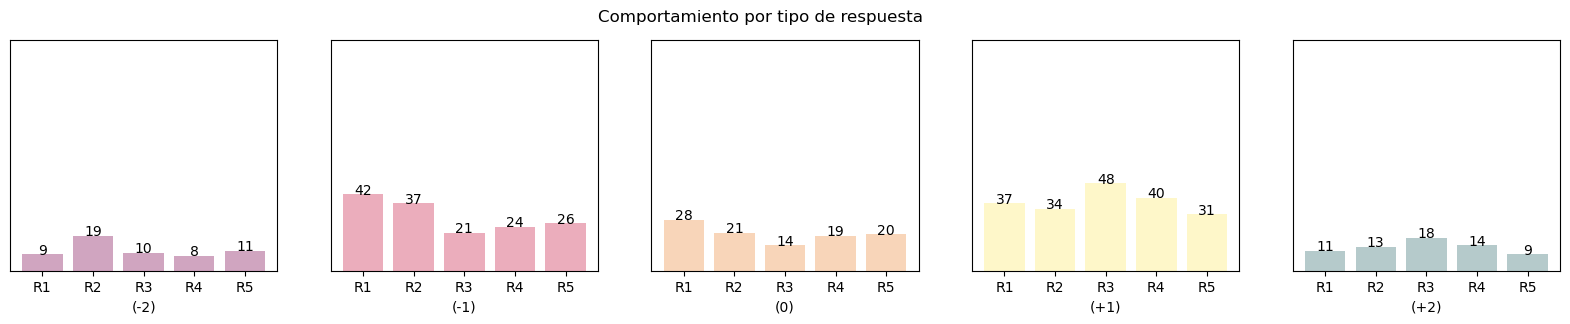

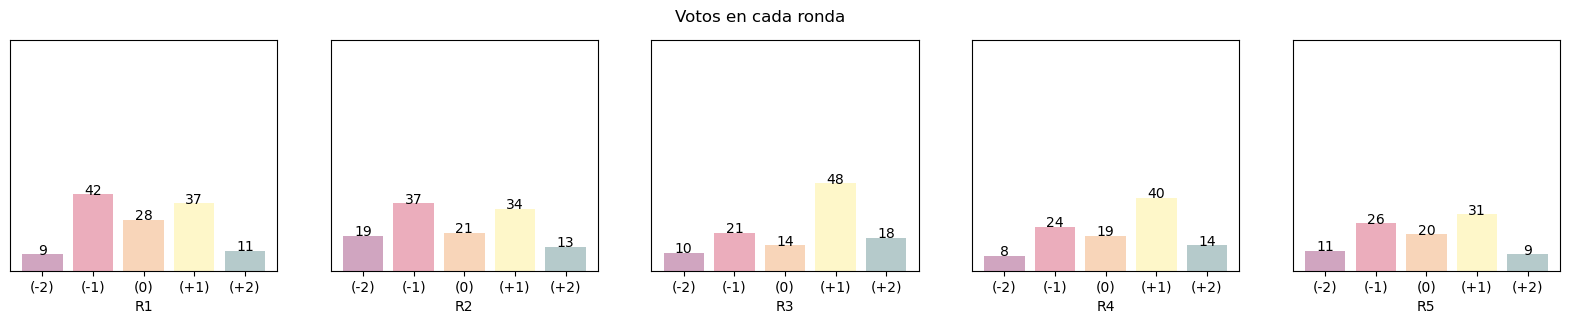

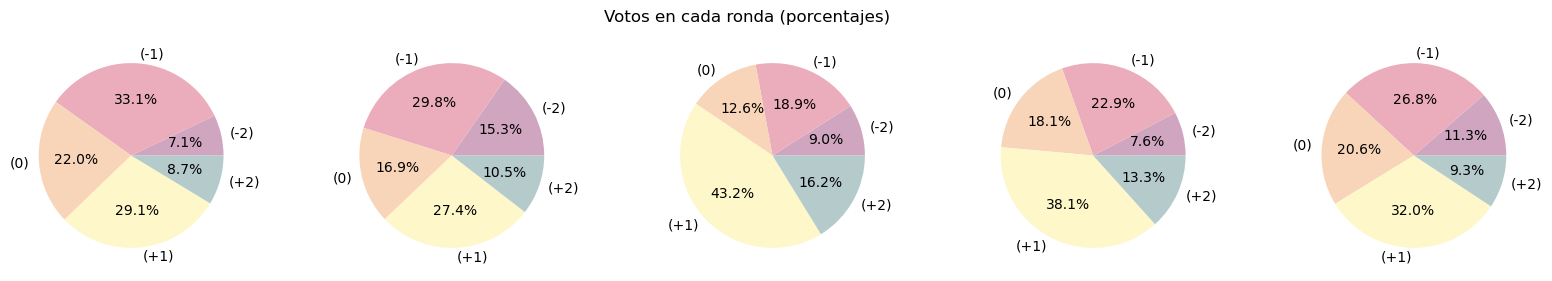

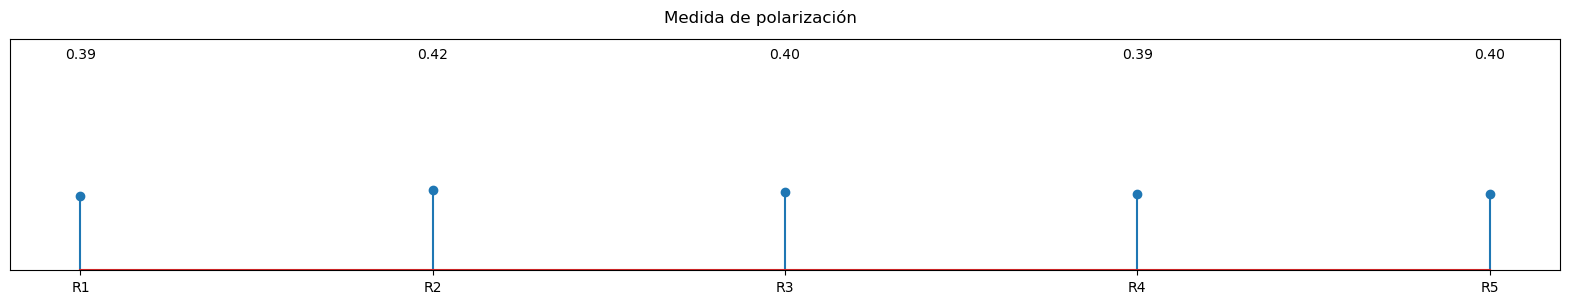

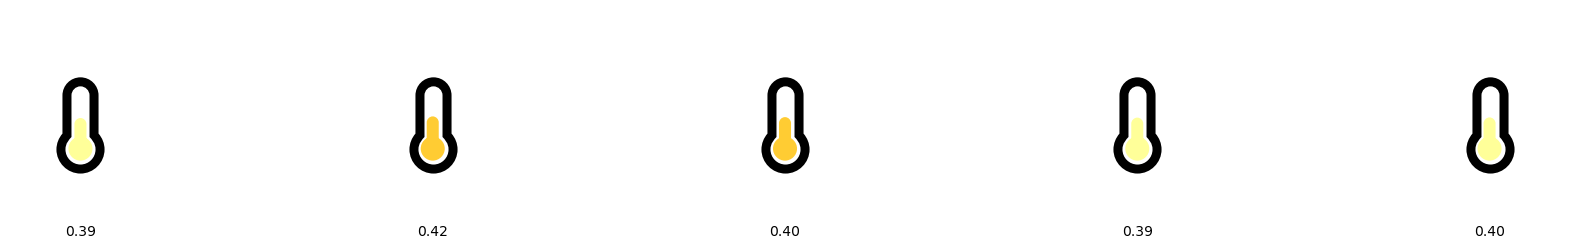

In [1]:
#Computing Esteban and Ray (E&R) polarization measures for different rounds. This
#notebook was used in the Promueva event at Javeriana University (23/08/2023)

#Data is imported from the file data.xls. Since the population is not the same
#in each round, the E&R measure is computed as a fraction n/m where m
#is the higuer possible measure (see function maxPolarization) and 
#n is the E&R measure computed with K=1 

## QUESTIONS: 
# El riesgo de que Inteligencias Artificiales como ChatGPT causen perjuicios a 
# la humanidad supera su potencial de generar beneficios para ésta

## Possible answers: see LTITLES below 

import pandas as pd
from math import pow
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath

########################################
# Some Constants 
########################################
LTITLES = ['(-2) Totalmente en desacuerdo',
           '(-1) Moderadamente en desacuerdo',
           '( 0) Ni de acuerdo, ni en desacuerdo',
           '(+1) Moderadamente de Acuerdo',
           '(+2) Totalmente de Acuerdo']

LTITLES_SHORT = [ '(-2)' , '(-1)', '(0)', '(+1)' , '(+2)']
NUMBINS = len(LTITLES) 
NUMCOLS = len(LTITLES_SHORT)

COLORS = ['#d0a5c0','#ebadbc','#f8d5b9', '#fef7c9', '#b5cacb', '#b5cacb', '#f5a87d'] * 10
FIGSIZE = (20,3)

ALPHA = 0.6
DISTANCE = 0.2 # Between bins 

########################################
# Polarization measures
########################################
def polarization(bins, K=1.0, alpha=0.6, distance=0.2):
  '''Esteban-Ray polarization meassure

  Parameters
  ----------
    bins : int list
      Population in each bin
    K : float
      Normalization constant
    alpha : float
      Identification constant
    distance : float
      Disntance between the bin i and i+1
  '''
  sum = 0.0
  for i, pi in enumerate(bins):
    for j, pj in enumerate(bins):
      sum += pow(pi, 1 + alpha) * pj * distance * abs(i - j)

  return K * sum

def maxPolarization(bins, K=1.0, alpha=0.6, distance=0.2):
    '''
    Maximal value for polarization when 1/2 of the population 
    is in each extreme
    '''
    
    population = sum(bins)
    n = len(bins)
    binextreme = [0] * n
    binextreme[0] = population/2
    binextreme[n-1] = population/2
    
    return polarization(binextreme, K,alpha, distance)

########################################
# Drawing thermometers 
########################################
# Taken from https://stackoverflow.com/questions/54790467/how-to-plot-a-thermometer
class TemperaturePlot():

    @staticmethod
    def get_hull():
        verts1 = np.array([[0,-128],[70,-128],[128,-70],[128,0],
                          [128,32.5],[115.8,61.5],[96,84.6],[96,288],
                          [96,341],[53,384],[0,384]])
        verts2 = verts1[:-1,:] * np.array([-1,1])
        codes1 = [1,4,4,4,4,4,4,2,4,4,4]
        verts3 = np.array([[0,-80],[44,-80],[80,-44],[80,0],
                          [80,34.3],[60.7,52],[48,66.5],[48,288],
                          [48,314],[26.5,336],[0,336]])
        verts4 = verts3[:-1,:] * np.array([-1,1])
        verts = np.concatenate((verts1, verts2[::-1], verts4, verts3[::-1]))
        codes = codes1 + codes1[::-1][:-1]
        return mpath.Path(verts/256., codes+codes)

    @staticmethod
    def get_mercury(s=1):
        a = 0; b = 64; c = 35
        d = 320 - b
        e = (1-s)*d
        verts1 = np.array([[a,-b],[c,-b],[b,-c],[b,a],[b,c],[c,b],[a,b]])
        verts2 = verts1[:-1,:] * np.array([-1,1])
        verts3 = np.array([[0,0],[32,0],[32,288-e],[32,305-e],
                           [17.5,320-e],[0,320-e]])
        verts4 = verts3[:-1,:] * np.array([-1,1])
        codes = [1] + [4]*12 + [1,2,2,4,4,4,4,4,4,2,2]
        verts = np.concatenate((verts1, verts2[::-1], verts3, verts4[::-1]))
        return mpath.Path(verts/256., codes)

    def scatter(self, x,y, temp=1, tempnorm=None, ax=None, **kwargs):
        self.ax = ax or plt.gca()
        temp = np.atleast_1d(temp)
        ec = kwargs.pop("edgecolor", "black")
        kwargs.update(linewidth=0)
        self.inner = self.ax.scatter(x,y, **kwargs)
        kwargs.update(c=None, facecolor=ec, edgecolor=None, color=None)
        self.outer = self.ax.scatter(x,y, **kwargs)
        self.outer.set_paths([self.get_hull()])
        if not tempnorm:
            mi, ma = np.nanmin(temp), np.nanmax(temp)
            if mi == ma:
                mi=0
            tempnorm = plt.Normalize(mi,ma)
        ipaths = [self.get_mercury(tempnorm(t)) for t in temp]
        self.inner.set_paths(ipaths)

def color(value):
    '''Color for the thermometer'''
    if value <=0.20: return 'blue'
    if value <=0.40: return '#ffff99'
    if value <=0.60: return '#ffcc33'
    if value <=0.80: return '#ee6600'
    return '#990000'  

########################################
# Input Data  
########################################
dataset = pd.read_excel('data.xlsx', sheet_name='data')
NUMROWS = len(dataset.index)
NUMROUNDS = NUMROWS


rows = [ dataset.loc[i, :].values.flatten().tolist() for i in dataset.index ]
data = [ {'data' : row[1:6]} for row in rows ]

roundlabels = dataset['Ronda'].values.tolist()

#Computing Esteban & Ray for each round
measure = [polarization(bins=row['data'], K=1.0, alpha=ALPHA, distance=DISTANCE) for row in data] 
maxmeasure = [maxPolarization(bins=row['data'], K=1.0, alpha=ALPHA, distance=DISTANCE) for row in data]
measurerate = [ t[0] / t[1] for t in zip(measure, maxmeasure)]

########################################
# Results and plot  
########################################
plt.style.context('fivethirtyeight')
YLIM = [0, sum(data[0]['data'])]


## Distribution of the population by areas
areas = ["Ingeniería y tec." , "C.. Naturales y Exac." , "C. Sociales" , "C. Económicas" , "Humanidades" , "Artes" , "Salud" , "Administración" , "Educación" , "Psicología"]
pop_area = [60 , 6 , 12 , 3 , 6 , 14 , 11 , 7 , 3 , 3]
plt.figure(figsize=FIGSIZE)
plt.bar(areas, pop_area)
plt.suptitle("Población por área")
plt.savefig('poblacion.png')

## plots input data
print(dataset)
print([ "{:0.3f}".format(x)  for x in measurerate])


## plots per category
fig, axes = plt.subplots(1, NUMBINS, figsize=FIGSIZE)
fig.subplots_adjust(hspace=1)

for i,value in enumerate(LTITLES_SHORT):
    axes[i].set_ylim(YLIM)
    axes[i].set_xlabel(value)
    values = dataset.iloc[:,i+1].values.tolist()
    axes[i].bar(roundlabels, values, color = COLORS[i])
    axes[i].tick_params(left = False, right = False , labelleft = False )
    for idx, value in enumerate(values):
        axes[i].text(idx,value,str(value),ha = 'center')

fig.suptitle('Comportamiento por tipo de respuesta')
fig.savefig('1.png')

## Answers (using bars) in each round

fig, axes = plt.subplots(1, NUMROUNDS, figsize=FIGSIZE)
fig.subplots_adjust(hspace=0.75)
for i, d in enumerate(data):
    axes[i].set_ylim(YLIM)
    axes[i].bar(LTITLES_SHORT,d['data'],color = COLORS)
    axes[i].set_xlabel(f'R{i+1}')
    
    axes[i].tick_params(left = False, right = False , labelleft = False )
    for idx, value in enumerate(d['data']):
        axes[i].text(idx,value,str(value),ha = 'center')

fig.suptitle('Votos en cada ronda')
fig.savefig('2.png')

## Answers for each round (using pie charts)

fig, axes = plt.subplots(1, NUMROUNDS, figsize=FIGSIZE)
fig.subplots_adjust(hspace=0.75)
for i, d in enumerate(data):
    #plt.subplot(1,NUMROWS, 1+i)
    #axes[i].set_ylim(YLIM)
    axes[i].pie(d['data'],labels= LTITLES_SHORT, autopct='%1.1f%%', colors = COLORS)
    axes[i].tick_params(left = False, right = False , labelleft = False )
    
fig.suptitle('Votos en cada ronda (porcentajes)')
fig.savefig('3.png')

# Plot of the polarization measure 
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_ylim(0, 1.2)
ax.tick_params(left = False, right = False , labelleft = False )
ax.stem(roundlabels,measurerate)
for idx, value in enumerate(measurerate):
        ax.text(idx,1.1,"{:.2f}".format(value),ha = 'center')

fig.suptitle("Medida de polarización")
fig.savefig('4.png')

# Thermometers
fig, ax = plt.subplots(figsize=FIGSIZE)
p = TemperaturePlot()
ax.set_ylim(0, 50)
ax.axis('off')

termocolor = list(map(color, measurerate))
#p.scatter(termox, termoy, s=1500, temp=termohigh, tempnorm=(lambda x: 25 * x/2500), color=termocolor) 
p.scatter( list(range(NUMROUNDS)), [20]*NUMROUNDS, s=1200, temp=measurerate, tempnorm=(lambda x: x), color=termocolor) 
for idx, value in enumerate(measurerate):
        plt.text(idx,1.1,"{:.2f}".format(value),ha = 'center')

plt.savefig('5.png')

plt.show()





